<font size=6>
    <b>Analyze_Text.ipynb:</b> Analyze Text with Pandas and Watson Natural Language Understanding
 </font>

# Introduction

This notebook shows how the open source library [Text Extensions for Pandas](https://github.com/CODAIT/text-extensions-for-pandas) lets you use use [Pandas](https://pandas.pydata.org/) DataFrames and the [Watson Natural Language Understanding](https://www.ibm.com/cloud/watson-natural-language-understanding) service to analyze natural language text. 

We start out with an excerpt from the [plot synopsis from the Wikipedia page
for *Monty Python and the Holy Grail*](https://en.wikipedia.org/wiki/Monty_Python_and_the_Holy_Grail#Plot). 
We pass this example document to the Watson Natural Language 
Understanding (NLU) service. Then we use Text Extensions for Pandas to convert the output of the 
Watson NLU service to Pandas DataFrames. Next, we perform an example analysis task both with 
and without Pandas to show how Pandas makes analyzing NLP information easier. Finally, we 
walk through all the different DataFrames that Text Extensions for Pandas can extract from 
the output of Watson Natural Language Understanding.

# Environment Setup

This notebook requires a Python 3.7 or later environment with the following packages:
* The dependencies listed in the ["requirements.txt" file for Text Extensions for Pandas](https://github.com/CODAIT/text-extensions-for-pandas/blob/master/requirements.txt)
* The "[ibm-watson](https://pypi.org/project/ibm-watson/)" package, available via `pip install ibm-watson`
* `text_extensions_for_pandas`

You can satisfy the dependency on `text_extensions_for_pandas` in either of two ways:

* Run `pip install text_extensions_for_pandas` before running this notebook. This command adds the library to your Python environment.
* Run this notebook out of your local copy of the Text Extensions for Pandas project's [source tree](https://github.com/CODAIT/text-extensions-for-pandas). In this case, the notebook will use the version of Text Extensions for Pandas in your local source tree **if the package is not installed in your Python environment**.

In [1]:
# Core Python libraries
import json
import os
import sys
import pandas as pd
from typing import *

# IBM Watson libraries
import ibm_watson
import ibm_watson.natural_language_understanding_v1 as nlu
import ibm_cloud_sdk_core

# And of course we need the text_extensions_for_pandas library itself.
try:
    import text_extensions_for_pandas as tp
except ModuleNotFoundError as e:
    # If we're running from within the project source tree and the parent Python
    # environment doesn't have the text_extensions_for_pandas package, use the
    # version in the local source tree.
    if not os.getcwd().endswith("notebooks"):
        raise e
    if ".." not in sys.path:
        sys.path.insert(0, "..")
    import text_extensions_for_pandas as tp

# Set up the Watson Natural Language Understanding Service

In this part of the notebook, we will use the Watson Natural Language Understanding (NLU) service to extract key features from our example document.

You can create an instance of Watson NLU on the IBM Cloud for free by navigating to [this page](https://www.ibm.com/cloud/watson-natural-language-understanding) and clicking on the button marked "Get started free". You can also install your own instance of Watson NLU on [OpenShift](https://www.openshift.com/) by using [IBM Watson Natural Language Understanding for IBM Cloud Pak for Data](
https://catalog.redhat.com/software/operators/detail/5e9873e13f398525a0ceafe5).

You'll need two pieces of information to access your instance of Watson NLU: An **API key** and a **service URL**. If you're using Watson NLU on the IBM Cloud, you can find your API key and service URL in the IBM Cloud web UI. Navigate to the [resource list](https://cloud.ibm.com/resources) and click on your instance of Natural Language Understanding to open the management UI for your service. Then click on the "Manage" tab to show a page with your API key and service URL.

The cell that follows assumes that you are using the environment variables `IBM_API_KEY` and `IBM_SERVICE_URL` to store your credentials. If you're running this notebook in Jupyter on your laptop, you can set these environment variables while starting up `jupyter notebook` or `jupyter lab`. For example:
``` console
IBM_API_KEY='<my API key>' \
IBM_SERVICE_URL='<my service URL>' \
  jupyter lab
```

Alternately, you can uncomment the first two lines of code below to set the `IBM_API_KEY` and `IBM_SERVICE_URL` environment variables directly.
**Be careful not to store your API key in any publicly-accessible location!**

In [2]:
# If you need to embed your credentials inline, uncomment the following two lines and
# paste your credentials in the indicated locations.
os.environ["IBM_API_KEY"] = "FWZd3Go3Kr9xfTF3bTns5YqCXW1-RiZ6hldC5GLb8FRw"
os.environ["IBM_SERVICE_URL"] = "https://api.us-south.natural-language-understanding.watson.cloud.ibm.com/instances/21b9b875-4ddb-46ad-bb22-d78747622ca7"

# Retrieve the API key for your Watson NLU service instance
if "IBM_API_KEY" not in os.environ:
    raise ValueError("Expected Watson NLU api key in the environment variable 'IBM_API_KEY'")
api_key = os.environ.get("IBM_API_KEY")
    
# Retrieve the service URL for your Watson NLU service instance
if "IBM_SERVICE_URL" not in os.environ:
    raise ValueError("Expected Watson NLU service URL in the environment variable 'IBM_SERVICE_URL'")
service_url = os.environ.get("IBM_SERVICE_URL")  

# Connect to the Watson Natural Language Understanding Python API

This notebook uses the IBM Watson Python SDK to perform authentication on the IBM Cloud via the 
`IAMAuthenticator` class. See [the IBM Watson Python SDK documentation](https://github.com/watson-developer-cloud/python-sdk#iam) for more information. 

We start by using the API key and service URL from the previous cell to create an instance of the
Python API for Watson NLU.

In [3]:
natural_language_understanding = ibm_watson.NaturalLanguageUnderstandingV1(
    version="2019-07-12",
    authenticator=ibm_cloud_sdk_core.authenticators.IAMAuthenticator(api_key)
)
natural_language_understanding.set_service_url(service_url)
natural_language_understanding

# Pass a Document through the Watson NLU Service

Once you've opened a connection to the Watson NLU service, you can pass documents through 
the service by invoking the [`analyze()` method](https://cloud.ibm.com/apidocs/natural-language-understanding?code=python#analyze).

The [example document](https://raw.githubusercontent.com/CODAIT/text-extensions-for-pandas/master/resources/holy_grail_short.txt) that we use here is an excerpt from
the plot summary for *Monty Python and the Holy Grail*, drawn from the [Wikipedia entry](https://en.wikipedia.org/wiki/Monty_Python_and_the_Holy_Grail) for that movie.

Let's show what the raw text looks like:

In [4]:
from IPython.core.display import display, HTML
doc_file = "../resources/holy_grail_short.txt"
with open(doc_file, "r") as f:
    doc_text = f.read()
    
display(HTML(f"<b>Document Text:</b><blockquote>{doc_text}</blockquote>"))

In the code below, we instruct Watson Natural Language Understanding to perform five different kinds of analysis on the example document:
* entities (with sentiment)
* keywords (with sentiment and emotion)
* relations
* semantic_roles
* syntax (with sentences, tokens, and part of speech)

See [the Watson NLU documentation](https://cloud.ibm.com/apidocs/natural-language-understanding?code=python#text-analytics-features) for a full description of the types of analysis that NLU can perform.

In [5]:
# Make the request
response = natural_language_understanding.analyze(
    text=doc_text,
    # TODO: Use this URL once we've pushed the shortened document to Github
    #url="https://raw.githubusercontent.com/CODAIT/text-extensions-for-pandas/master/resources/holy_grail_short.txt",
    return_analyzed_text=True,
    features=nlu.Features(
        entities=nlu.EntitiesOptions(sentiment=True, mentions=True),
        keywords=nlu.KeywordsOptions(sentiment=True, emotion=True),
        relations=nlu.RelationsOptions(),
        semantic_roles=nlu.SemanticRolesOptions(),
        syntax=nlu.SyntaxOptions(sentences=True, 
                                 tokens=nlu.SyntaxOptionsTokens(lemma=True, part_of_speech=True))
    )).get_result()

The response from the `analyze()` method is a Python dictionary. The dictionary contains an entry 
for each pass of analysis requested, plus some additional entries with metadata about the API request
itself. Here's a list of the keys in `response`:

In [6]:
response.keys()

dict_keys(['usage', 'syntax', 'semantic_roles', 'relations', 'language', 'keywords', 'entities', 'analyzed_text'])

# Perform an Example Task

Let's use the information that Watson Natural Language Understanding has extracted from our example document to perform an example task: *Find all the pronouns in each sentence, broken down by sentence.*

This task could serve as first step to a number of more complex tasks, such as 
resolving anaphora (for example, associating "King Arthur" with "his" in the phrase "King Arthur and his squire, Patsy") or analyzing the relationship between sentiment and the gender of pronouns.

We'll start by doing this task using straight Python code that operates directly over the output of Watson NLU's `analyze()` method. Then we'll redo the task using Pandas DataFrames and Text Extensions for Pandas. This exercise will show how Pandas DataFrames can represent the intermediate data structures of an NLP application in a way that is both easier to understand and easier to manipulate with less code.

Let's begin.

## Perform the Task Without Using Pandas

All the information that we need to perform our task is in the "syntax" section of the response 
we captured above from Watson NLU's `analyze()` method. Syntax analysis captures a large amount
of information, so the "syntax" section of the response is very verbose. 

For reference, here's the text of our example document again:



In [7]:
display(HTML(f"<b>Document Text:</b><blockquote>{doc_text}</blockquote>"))

And here's the output of Watson NLU's syntax analysis, converted to a string:

In [8]:
response["syntax"]

{'tokens': [{'text': 'In',
   'part_of_speech': 'ADP',
   'location': [0, 2],
   'lemma': 'in'},
  {'text': 'AD', 'part_of_speech': 'NOUN', 'location': [3, 5], 'lemma': 'ad'},
  {'text': '932', 'part_of_speech': 'NUM', 'location': [6, 9]},
  {'text': ',', 'part_of_speech': 'PUNCT', 'location': [9, 10]},
  {'text': 'King',
   'part_of_speech': 'PROPN',
   'location': [11, 15],
   'lemma': 'king'},
  {'text': 'Arthur', 'part_of_speech': 'PROPN', 'location': [16, 22]},
  {'text': 'and',
   'part_of_speech': 'CCONJ',
   'location': [23, 26],
   'lemma': 'and'},
  {'text': 'his',
   'part_of_speech': 'PRON',
   'location': [27, 30],
   'lemma': 'his'},
  {'text': 'squire',
   'part_of_speech': 'NOUN',
   'location': [31, 37],
   'lemma': 'squire'},
  {'text': ',', 'part_of_speech': 'PUNCT', 'location': [37, 38]},
  {'text': 'Patsy',
   'part_of_speech': 'PROPN',
   'location': [39, 44],
   'lemma': 'patsy'},
  {'text': ',', 'part_of_speech': 'PUNCT', 'location': [44, 45]},
  {'text': 'trave

Buried in the above data structure is all the information we need to perform our example task:
* The location of every token in the document.
* The part of speech of every token in the document.
* The location of every sentence in the document.

The Python code in the next cell uses this information to construct a list of pronouns
in each sentence in the document.

In [9]:
import collections

# Create a data structure to hold a mapping from sentence identifier
# to a list of pronouns. This step requires defining sentence ids.
def sentence_id(sentence_record: Dict[str, Any]):
    return tuple(sentence_record["location"])

pronouns_by_sentence_id = collections.defaultdict(list)

# Pass 1: Use nested for loops to identify pronouns and match them with 
#         their containing sentences.
# Running time: O(num_tokens * num_sentences), i.e. O(document_size^2)
for t in response["syntax"]["tokens"]:
    pos_str = t["part_of_speech"]  # Decode numeric POS enum
    if pos_str == "PRON":
        found_sentence = False
        for s in response["syntax"]["sentences"]:
            if (t["location"][0] >= s["location"][0] 
                    and t["location"][1] <= s["location"][1]):
                found_sentence = True
                pronouns_by_sentence_id[sentence_id(s)].append(t)
        if not found_sentence:
            raise ValueError(f"Token {t} is not in any sentence")
            pass  # Make JupyterLab syntax highlighting happy

# Pass 2: Translate sentence identifiers to full sentence metadata.
sentence_id_to_sentence = {sentence_id(s): s 
                           for s in response["syntax"]["sentences"]}
result = [
    {
        "sentence": sentence_id_to_sentence[key],
        "pronouns": pronouns
    }
    for key, pronouns in pronouns_by_sentence_id.items()
]
result

[{'sentence': {'text': 'In AD 932, King Arthur and his squire, Patsy, travel throughout Britain searching for men to join the Knights of the Round Table.',
   'location': [0, 129]},
  'pronouns': [{'text': 'his',
    'part_of_speech': 'PRON',
    'location': [27, 30],
    'lemma': 'his'}]},
 {'sentence': {'text': "Along the way, he recruits Sir Bedevere the Wise, Sir Lancelot the Brave, Sir Galahad the Pure, Sir Robin the Not-Quite-So-Brave-as-Sir-Lancelot, and Sir Not-Appearing-in-this-Film, along with their squires and Robin's troubadours.",
   'location': [130, 361]},
  'pronouns': [{'text': 'he',
    'part_of_speech': 'PRON',
    'location': [145, 147],
    'lemma': 'he'},
   {'text': 'this',
    'part_of_speech': 'PRON',
    'location': [301, 305],
    'lemma': 'this'},
   {'text': 'their',
    'part_of_speech': 'PRON',
    'location': [323, 328],
    'lemma': 'their'}]},
 {'sentence': {'text': 'Arthur leads the men to Camelot, but upon further consideration (thanks to a musical n

The code above is quite complex given the simplicity of the task. You would need to stare at the previous cell for a few minutes to convince yourself that the algorithm is correct. This implementation also has scalability issues: The worst-case running time of the nested for loops section is proportional to the square of the document length.

We can do better.

## Repeat the Example Task Using Pandas

Let's revisit the example task we just performed in the previous cell. Again, the task is: *Find all the pronouns in each sentence, broken down by sentence.* This time around, let's perform this task using Pandas.

Text Extensions for Pandas includes a function `parse_response()` that turns the output of Watson NLU's `analyze()` function into a dictionary of Pandas DataFrames. Let's run our response object through that conversion.

In [10]:
dfs = tp.io.watson.nlu.parse_response(response)
dfs.keys()

dict_keys(['syntax', 'entities', 'entity_mentions', 'keywords', 'relations', 'semantic_roles'])

The output of each analysis pass that Watson NLU performed is now a DataFrame. 
Let's look at the DataFrame for the "syntax" pass:

In [11]:
syntax_df = dfs["syntax"]
syntax_df

,span,part_of_speech,lemma,sentence
0,"[0, 2): 'In'",ADP,in,"[0, 129): 'In AD 932, King Arthur and his squi..."
1,"[3, 5): 'AD'",NOUN,ad,"[0, 129): 'In AD 932, King Arthur and his squi..."
2,"[6, 9): '932'",NUM,None,"[0, 129): 'In AD 932, King Arthur and his squi..."
3,"[9, 10): ','",PUNCT,None,"[0, 129): 'In AD 932, King Arthur and his squi..."
4,"[11, 15): 'King'",PROPN,king,"[0, 129): 'In AD 932, King Arthur and his squi..."
...,...,...,...,...
142,"[606, 613): 'finding'",VERB,find,"[513, 629): 'As they turn away, God (an image ..."
143,"[614, 617): 'the'",DET,the,"[513, 629): 'As they turn away, God (an image ..."
144,"[618, 622): 'Holy'",PROPN,None,"[513, 629): 'As they turn away, God (an image ..."
145,"[623, 628): 'Grail'",PROPN,None,"[513, 629): 'As they turn away, God (an image ..."


The DataFrame has one row for every token in the document. Each row has information on
the span of the token, its part of speech, its lemmatized form, and the span of the 
containing sentence.

Let's use this DataFrame to perform our example task a second time.

In [12]:
pronouns_by_sentence = syntax_df[syntax_df["part_of_speech"] == "PRON"][["sentence", "span"]]
pronouns_by_sentence

,sentence,span
7,"[0, 129): 'In AD 932, King Arthur and his squi...","[27, 30): 'his'"
31,"[130, 361): 'Along the way, he recruits Sir Be...","[145, 147): 'he'"
73,"[130, 361): 'Along the way, he recruits Sir Be...","[301, 305): 'this'"
79,"[130, 361): 'Along the way, he recruits Sir Be...","[323, 328): 'their'"
104,"[362, 512): 'Arthur leads the men to Camelot, ...","[455, 457): 'he'"
111,"[362, 512): 'Arthur leads the men to Camelot, ...","[490, 492): 'it'"
120,"[513, 629): 'As they turn away, God (an image ...","[516, 520): 'they'"
135,"[513, 629): 'As they turn away, God (an image ...","[572, 576): 'them'"


That's it. With the DataFrame version of this data, we can perform our example task with **one line of code**.

Specifically, we use a Pandas selection condition to filter out the tokens that aren't pronouns, and then then we 
project down to the columns containing sentence and token spans. The result is another DataFrame that 
we can display directly in our Jupyter notebook.

# How it Works


Let's take a moment to drill into the internals of the DataFrames we just used.
For reference, here are the first three rows of the syntax analysis DataFrame:

In [13]:
syntax_df.head(3)

,span,part_of_speech,lemma,sentence
0,"[0, 2): 'In'",ADP,in,"[0, 129): 'In AD 932, King Arthur and his squi..."
1,"[3, 5): 'AD'",NOUN,ad,"[0, 129): 'In AD 932, King Arthur and his squi..."
2,"[6, 9): '932'",NUM,None,"[0, 129): 'In AD 932, King Arthur and his squi..."


And here is that DataFrame's data type information:

In [14]:
syntax_df.dtypes

span                   SpanDtype
part_of_speech            object
lemma                     object
sentence          TokenSpanDtype
dtype: object

Two of the columns in this DataFrame &mdash; "span" and "sentence" &mdash; contain
extension types from the Text Extensions for Pandas library. Let's look first at the "span"
column. 

The "span" column is stored internally using the class `SpanArray` from 
Text Extensions for Pandas.
`SpanArray` is a subclass of 
[`ExtensionArray`](
    https://pandas.pydata.org/docs/reference/api/pandas.api.extensions.ExtensionArray.html), 
the base class for custom 1-D array types in Pandas.

You can use the property [`pandas.Series.array`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.array.html) to access the `ExtensionArray` behind any Pandas extension type:

In [15]:
print(syntax_df["span"].array)

<SpanArray>
[         [0, 2): 'In',          [3, 5): 'AD',         [6, 9): '932',
          [9, 10): ',',      [11, 15): 'King',    [16, 22): 'Arthur',
       [23, 26): 'and',       [27, 30): 'his',    [31, 37): 'squire',
         [37, 38): ',',
 ...
   [581, 586): 'gives',  [587, 593): 'Arthur',     [594, 597): 'the',
    [598, 602): 'task',      [603, 605): 'of', [606, 613): 'finding',
     [614, 617): 'the',    [618, 622): 'Holy',   [623, 628): 'Grail',
       [628, 629): '.']
Length: 147, dtype: SpanDtype


Internally, a `SpanArray` is stored as Numpy arrays of begin and end offsets, plus a Python string 
containing the target text. You can access this internal data as properties if your application needs that
information:

In [16]:
syntax_df["span"].array.begin[:10], syntax_df["span"].array.end[:10]

(array([ 0,  3,  6,  9, 11, 16, 23, 27, 31, 37]),
 array([ 2,  5,  9, 10, 15, 22, 26, 30, 37, 38]))

You can also convert an individual element of the array into a Python object of type `Span`:

In [17]:
span_obj = syntax_df["span"].array[0]
print(f"\"{span_obj}\" is an object of type {type(span_obj)}")

"[0, 2): 'In'" is an object of type <class 'text_extensions_for_pandas.array.span.Span'>


Or you can convert the entire array (or a slice of it) into Python objects, one object per span:

In [18]:
syntax_df["span"].iloc[:10].to_numpy()

array([[0, 2): 'In', [3, 5): 'AD', [6, 9): '932', [9, 10): ',',
       [11, 15): 'King', [16, 22): 'Arthur', [23, 26): 'and',
       [27, 30): 'his', [31, 37): 'squire', [37, 38): ','], dtype=object)

A `SpanArray` can also render itself using [Jupyter Notebook callbacks](https://ipython.readthedocs.io/en/stable/config/integrating.html). To
see the HTML representation of the `SpanArray`, pass the array object
to Jupyter's [`display()`](https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html#IPython.display.display)
function; or make that object be the last line of the cell, as in the following example:

In [19]:
# Show the first 10 tokens in context
syntax_df["span"].iloc[:10].array

,begin,end,covered_text
0,0,2,In
1,3,5,AD
2,6,9,932
3,9,10,","
4,11,15,King
5,16,22,Arthur
6,23,26,and
7,27,30,his
8,31,37,squire
9,37,38,","


Let's take another look at our DataFrame of syntax information:

In [20]:
syntax_df.head(3)

,span,part_of_speech,lemma,sentence
0,"[0, 2): 'In'",ADP,in,"[0, 129): 'In AD 932, King Arthur and his squi..."
1,"[3, 5): 'AD'",NOUN,ad,"[0, 129): 'In AD 932, King Arthur and his squi..."
2,"[6, 9): '932'",NUM,None,"[0, 129): 'In AD 932, King Arthur and his squi..."


The "sentence" column is backed by an object of type `TokenSpanArray`.
`TokenSpanArray`, another extension type from Text Extensions for Pandas,
is a version of `SpanArray` for representing a set of spans that are 
constrained to begin and end on token boundaries. In addition to all the
functionality of a `SpanArray`, a `TokenSpanArray` encodes additional 
information about the relationships between its spans and a tokenization
of the document.

Here are the distinct elements of the "sentence" column rendered as HTML:

In [21]:
syntax_df["sentence"].unique()

,begin,end,begin_token,end_token,covered_text
0,0,129,0,27,"In AD 932, King Arthur and his squire, Patsy, travel throughout Britain searching for men to join the Knights of the Round Table."
1,130,361,27,86,"Along the way, he recruits Sir Bedevere the Wise, Sir Lancelot the Brave, Sir Galahad the Pure, Sir Robin the Not-Quite-So-Brave-as-Sir-Lancelot, and Sir Not-Appearing-in-this-Film, along with their squires and Robin's troubadours."
2,362,512,86,119,"Arthur leads the men to Camelot, but upon further consideration (thanks to a musical number) he decides not to go there because it is ""a silly place""."
3,513,629,119,147,"As they turn away, God (an image of W. G. Grace) speaks to them and gives Arthur the task of finding the Holy Grail."


As the table in the previous cell's output shows, each span in the `TokenSpanArray` has begin and end offsets in terms 
of both characters and tokens. Internally, the `TokenSpanArray` is stored as follows:
* A Numpy array of begin offsets, measured in tokens
* A Numpy array of end offsets in tokens
* A reference to a `SpanArray` of spans representing the tokens

The `TokenSpanArray` object computes the character offsets and covered text of its spans on demand.

Applications can access the internals of a `TokenSpanArray` via the properties `begin_token`, `end_token`, and `tokens`:

In [22]:
token_span_array = syntax_df["sentence"].unique()
print(f"""
Offset information (stored in the TokenSpanArray):
`begin_token` property: {token_span_array.begin_token}
  `end_token` property: {token_span_array.end_token}
   
Token information (`tokens` property, shared among mulitple TokenSpanArrays):
{token_span_array.tokens}
""")


Offset information (stored in the TokenSpanArray):
`begin_token` property: [  0  27  86 119]
  `end_token` property: [ 27  86 119 147]
   
Token information (`tokens` property, shared among mulitple TokenSpanArrays):
<SpanArray>
[         [0, 2): 'In',          [3, 5): 'AD',         [6, 9): '932',
          [9, 10): ',',      [11, 15): 'King',    [16, 22): 'Arthur',
       [23, 26): 'and',       [27, 30): 'his',    [31, 37): 'squire',
         [37, 38): ',',
 ...
   [581, 586): 'gives',  [587, 593): 'Arthur',     [594, 597): 'the',
    [598, 602): 'task',      [603, 605): 'of', [606, 613): 'finding',
     [614, 617): 'the',    [618, 622): 'Holy',   [623, 628): 'Grail',
       [628, 629): '.']
Length: 147, dtype: SpanDtype



The extension types in Text Extensions for Pandas support the full set of Pandas array operations. For example, we can build up a DataFrame of the spans of all sentences in the document by applying `pandas.DataFrame.drop_duplicates()` to the `sentence` column:

In [23]:
syntax_df[["sentence"]].drop_duplicates()

,sentence
0,"[0, 129): 'In AD 932, King Arthur and his squi..."
27,"[130, 361): 'Along the way, he recruits Sir Be..."
86,"[362, 512): 'Arthur leads the men to Camelot, ..."
119,"[513, 629): 'As they turn away, God (an image ..."


# A More Complex Example

Now that we've had an introduction to the Text Extensions for Pandas span types, let's take another
look at the DataFrame that our "find pronouns by sentence" code produced:

In [24]:
pronouns_by_sentence

,sentence,span
7,"[0, 129): 'In AD 932, King Arthur and his squi...","[27, 30): 'his'"
31,"[130, 361): 'Along the way, he recruits Sir Be...","[145, 147): 'he'"
73,"[130, 361): 'Along the way, he recruits Sir Be...","[301, 305): 'this'"
79,"[130, 361): 'Along the way, he recruits Sir Be...","[323, 328): 'their'"
104,"[362, 512): 'Arthur leads the men to Camelot, ...","[455, 457): 'he'"
111,"[362, 512): 'Arthur leads the men to Camelot, ...","[490, 492): 'it'"
120,"[513, 629): 'As they turn away, God (an image ...","[516, 520): 'they'"
135,"[513, 629): 'As they turn away, God (an image ...","[572, 576): 'them'"


This DataFrame contains two columns backed by Text Extensions for Pandas span types:

In [25]:
pronouns_by_sentence.dtypes

sentence    TokenSpanDtype
span             SpanDtype
dtype: object

That means that we can use the full power of Pandas' high-level operations on this DataFrame. 
Let's use the output of our earlier task to build up a more complex task: 
*Highlight all pronouns in sentences containing the word "Arthur"*

In [26]:
mask = pronouns_by_sentence["sentence"].map(lambda s: s.covered_text).str.contains("Arthur")
pronouns_by_sentence["span"][mask].values

,begin,end,covered_text
0,27,30,his
1,455,457,he
2,490,492,it
3,516,520,they
4,572,576,them


Here's another variation: *Pair each instance of the word "Arthur" with the pronouns that occur in the same sentence.*

In [27]:
(
    syntax_df[syntax_df["span"].array.covered_text == "Arthur"]  # Find instances of "Arthur"
    .merge(pronouns_by_sentence, on="sentence")  # Match with pronouns in the same sentence
    .rename(columns={"span_x": "arthur_span", "span_y": "pronoun_span"})
    [["arthur_span", "pronoun_span", "sentence"]]  # Reorder columns
)

,arthur_span,pronoun_span,sentence
0,"[16, 22): 'Arthur'","[27, 30): 'his'","[0, 129): 'In AD 932, King Arthur and his squi..."
1,"[362, 368): 'Arthur'","[455, 457): 'he'","[362, 512): 'Arthur leads the men to Camelot, ..."
2,"[362, 368): 'Arthur'","[490, 492): 'it'","[362, 512): 'Arthur leads the men to Camelot, ..."
3,"[587, 593): 'Arthur'","[516, 520): 'they'","[513, 629): 'As they turn away, God (an image ..."
4,"[587, 593): 'Arthur'","[572, 576): 'them'","[513, 629): 'As they turn away, God (an image ..."


# Other Outputs of Watson NLU as DataFrames 

The examples so far have used the DataFrame representation of Watson Natural Language Understanding's syntax analysis.
In addition to syntax analysis, Watson NLU can perform several other types of analysis. Let's take a look at the 
DataFrames that Text Extensions for Pandas can produce from the output of Watson NLU.

We'll start by revisiting the results of our earlier code that ran 
```python
dfs = tp.io.watson.nlu.parse_response(response)
```
over the `response` object that the Watson NLU's Python API returned. `dfs` is a dictionary of DataFrames.

In [28]:
dfs.keys()

dict_keys(['syntax', 'entities', 'entity_mentions', 'keywords', 'relations', 'semantic_roles'])

The "syntax" element of `dfs` contains the syntax analysis DataFrame that we showed earlier.
Let's take a look at the other elements.

The "entities" element of `dfs` contains the named entities that Watson Natural Language 
Understanding found in the document.

In [29]:
dfs["entities"].head()

,type,text,sentiment.label,sentiment.score,relevance,count,confidence,disambiguation.subtype,disambiguation.name,disambiguation.dbpedia_resource
0,Person,Sir Bedevere,positive,0.835873,0.950560,1,0.982315,None,None,None
1,Person,King Arthur,neutral,0.000000,0.720381,1,0.924937,None,None,None
2,Person,Patsy,neutral,0.000000,0.679300,1,0.830596,None,None,None
3,Person,Sir Lancelot,positive,0.835873,0.662902,1,0.956371,"[MusicalArtist, TVActor]",Sir_Lancelot_%28singer%29,http://dbpedia.org/resource/Sir_Lancelot_%28si...
4,Person,Sir Galahad,positive,0.835873,0.654170,1,0.948409,None,None,None


The "entity_mentions" element of `dfs` contains the locations of individual mentions of
entities from the "entities" DataFrame. 

In [30]:
dfs["entity_mentions"].head()

,type,text,span,confidence
0,Person,Sir Bedevere,"[157, 169): 'Sir Bedevere'",0.982315
1,Person,King Arthur,"[11, 22): 'King Arthur'",0.924937
2,Person,Patsy,"[39, 44): 'Patsy'",0.830596
3,Person,Sir Lancelot,"[180, 192): 'Sir Lancelot'",0.956371
4,Person,Sir Galahad,"[204, 215): 'Sir Galahad'",0.948409


Note that the DataFrame under "entitiy_mentions" may contain multiple mentions of the same
name:

In [31]:
arthur_mentions = dfs["entity_mentions"][dfs["entity_mentions"]["text"] == "Arthur"]
arthur_mentions

,type,text,span,confidence
10,Person,Arthur,"[362, 368): 'Arthur'",0.996876
11,Person,Arthur,"[587, 593): 'Arthur'",0.973795


The "type" and "text" columns of the "entity_mentions" DataFrame refer back to the 
"entities" DataFrame columns of the same names.
You can combine the global and local information about entities into a single DataFrame
using Pandas' `DataFrame.merge()` method:

In [32]:
arthur_mentions.merge(dfs["entities"], on=["type", "text"], suffixes=["_mention", "_entity"])

,type,text,span,confidence_mention,sentiment.label,sentiment.score,relevance,count,confidence_entity,disambiguation.subtype,disambiguation.name,disambiguation.dbpedia_resource
0,Person,Arthur,"[362, 368): 'Arthur'",0.996876,positive,0.721918,0.311653,2,0.999918,None,None,None
1,Person,Arthur,"[587, 593): 'Arthur'",0.973795,positive,0.721918,0.311653,2,0.999918,None,None,None


In [33]:
dfs["keywords"].head()

,text,sentiment.label,sentiment.score,relevance,emotion.sadness,emotion.joy,emotion.fear,emotion.disgust,emotion.anger,count
0,King Arthur,neutral,0.000000,0.864073,0.062558,0.620066,0.054894,0.088147,0.182329,1
1,Sir Lancelot,positive,0.835873,0.820529,0.046902,0.810654,0.016340,0.095661,0.021033,1
2,image of W. G. Grace,positive,0.721918,0.758922,0.047242,0.614332,0.159497,0.040378,0.155298,1
3,Sir Galahad,positive,0.835873,0.635859,0.046902,0.810654,0.016340,0.095661,0.021033,1
4,musical number,neutral,0.000000,0.628727,0.057009,0.365688,0.054963,0.142391,0.054547,1


In [34]:
dfs["relations"].head()

,type,sentence_span,score,arguments.0.span,arguments.1.span,arguments.0.entities.type,arguments.1.entities.type,arguments.0.entities.text,arguments.1.entities.text
0,partOfMany,"[130, 361): 'Along the way, he recruits Sir Be...",0.610221,"[208, 215): 'Galahad'","[323, 328): 'their'",Person,Person,Galahad,their
1,partOfMany,"[130, 361): 'Along the way, he recruits Sir Be...",0.710112,"[266, 274): 'Lancelot'","[323, 328): 'their'",Person,Person,Lancelot,their
2,parentOf,"[130, 361): 'Along the way, he recruits Sir Be...",0.382100,"[323, 328): 'their'","[329, 336): 'squires'",Person,Person,their,squires
3,residesIn,"[362, 512): 'Arthur leads the men to Camelot, ...",0.492869,"[362, 368): 'Arthur'","[386, 393): 'Camelot'",Person,GeopoliticalEntity,King Arthur,Camelot
4,locatedAt,"[362, 512): 'Arthur leads the men to Camelot, ...",0.339446,"[379, 382): 'men'","[386, 393): 'Camelot'",Person,GeopoliticalEntity,men,Camelot


In [35]:
dfs["semantic_roles"].head()

,subject.text,sentence,object.text,action.verb.text,action.verb.tense,action.text,action.normalized
0,men,"In AD 932, King Arthur and his squire, Patsy, ...",the Knights of the Round Table,join,future,to join,to join
1,he,"Along the way, he recruits Sir Bedevere the W...",Sir Bedevere the Wise,recruit,present,recruits,recruit
2,Arthur,"Arthur leads the men to Camelot, but upon fur...",the men,lead,present,leads,lead
3,he,"Arthur leads the men to Camelot, but upon fur...",not to go there,decide,present,decides,decide
4,he,"Arthur leads the men to Camelot, but upon fur...",a musical number),go,future,to go,to go


# Sentiment Analysis Use Case
Let's explore another use case by applying the Watson Natural Language Understanding API over product reviews for conducting the keyword based sentiment analysis. To do so, we have downloaded [Edmunds-Consumer Car Ratings and Reviews](https://www.kaggle.com/ankkur13/edmundsconsumer-car-ratings-and-reviews) from the Kaggle website and copied that to our resources directory. 

In [627]:
dodge_rev = pd.read_csv('../resources/Scraped_Car_Review_dodge.csv',engine='python',index_col=False)
dodge_rev.head(10)

,Unnamed: 0,Review_Date,Author_Name,Vehicle_Title,Review_Title,Review,Rating
0,0,on 10/13/05 15:30 PM (PDT),roadking,2002 Dodge Ram Cargo Van 1500 3dr Van (3.9L 6c...,Great delivery vehicle,It's been a great delivery vehicle for my caf...,4.625
1,1,on 07/17/05 21:59 PM (PDT),Mark,2002 Dodge Ram Cargo Van 3500 3dr Ext Van (5.2...,Disappointmnet,Bought this car as a commuter vehicle for a v...,2.125
2,2,on 07/16/02 00:00 AM (PDT),Tom Sheer,2002 Dodge Ram Cargo Van 3500 Maxi 3dr Ext Van...,Sweet van,"This van rocks its the best, lots of \rroom. ...",5.000
3,3,on 12/29/07 21:57 PM (PST),Keven Smith,2001 Dodge Ram Cargo Van 2500 Maxi 3dr Ext Van...,Keven Smith,Great work vehicle. Drives nice. has lots of ...,4.500
4,4,on 02/09/05 18:52 PM (PST),VanMan,2001 Dodge Ram Cargo Van 1500 3dr Van (3.9L 6c...,Not what Dodge used to be,Good solid frame and suspension. Well equipp...,2.875
5,5,on 05/17/04 00:00 AM (PDT),driverage,2001 Dodge Ram Cargo Van 1500 3dr Van (3.9L 6c...,2001 dodge 1500 ram van,some very early body rust on roof,2.250
6,6,on 08/01/17 16:40 PM (PDT),Guy,2003 Dodge Ram Cargo Van 2500 3dr Ext Van (5.2...,Failur is lurking in every corner,Purchased the vehicle in 2003 second hand wit...,3.000
7,7,on 02/25/06 06:09 AM (PST),smithtp,2003 Dodge Ram Cargo Van 1500 3dr Ext Van (3.9...,Great Van,"Bought used with 34k,the conversion package b...",4.625
8,8,on 04/13/04 00:00 AM (PDT),Regency,2003 Dodge Ram Cargo Van 1500 3dr Ext Van (3.9...,2003 Conversion Van,This is a left over new van. Great deal,NaN
9,especially with the 0 % interest. Van,None,None,None,None,None,NaN


In [628]:
dodge_rev.shape

(11552, 7)

In [629]:
# Let's combine the review titles and Review to the review_content
dodge_rev['Review_Content']=dodge_rev['Review_Title']+ ':' + dodge_rev['Review']
dodge_rev.head()

,Unnamed: 0,Review_Date,Author_Name,Vehicle_Title,Review_Title,Review,Rating,Review_Content
0,0,on 10/13/05 15:30 PM (PDT),roadking,2002 Dodge Ram Cargo Van 1500 3dr Van (3.9L 6c...,Great delivery vehicle,It's been a great delivery vehicle for my caf...,4.625,Great delivery vehicle: It's been a great deli...
1,1,on 07/17/05 21:59 PM (PDT),Mark,2002 Dodge Ram Cargo Van 3500 3dr Ext Van (5.2...,Disappointmnet,Bought this car as a commuter vehicle for a v...,2.125,Disappointmnet: Bought this car as a commuter ...
2,2,on 07/16/02 00:00 AM (PDT),Tom Sheer,2002 Dodge Ram Cargo Van 3500 Maxi 3dr Ext Van...,Sweet van,"This van rocks its the best, lots of \rroom. ...",5.000,"Sweet van: This van rocks its the best, lots o..."
3,3,on 12/29/07 21:57 PM (PST),Keven Smith,2001 Dodge Ram Cargo Van 2500 Maxi 3dr Ext Van...,Keven Smith,Great work vehicle. Drives nice. has lots of ...,4.500,Keven Smith: Great work vehicle. Drives nice. ...
4,4,on 02/09/05 18:52 PM (PST),VanMan,2001 Dodge Ram Cargo Van 1500 3dr Van (3.9L 6c...,Not what Dodge used to be,Good solid frame and suspension. Well equipp...,2.875,Not what Dodge used to be: Good solid frame an...


Let's first apply watson NLU on the first review and analyze the output:

In [631]:
# Using Watson Natural Language Understanding for analyzing the Review_Content
# Make the request
response_review = natural_language_understanding.analyze(
    text=dodge_rev['Review_Content'][0],
    return_analyzed_text=True,
    features=nlu.Features(
        entities=nlu.EntitiesOptions(sentiment=True, mentions=True),
        keywords=nlu.KeywordsOptions(sentiment=True, emotion=True),
        relations=nlu.RelationsOptions(),
        semantic_roles=nlu.SemanticRolesOptions(),
        syntax=nlu.SyntaxOptions(sentences=True, 
                                 tokens=nlu.SyntaxOptionsTokens(lemma=True, part_of_speech=True)),
        sentiment=nlu.SentimentOptions(targets=['vehicle'])
    )).get_result()


The response from the analyze() method is a Python dictionary. The dictionary contains an entry for each pass of analysis requested, plus some additional entries with metadata about the API request itself. Here's a list of the keys in response:

In [632]:
response_review.keys()

dict_keys(['usage', 'syntax', 'sentiment', 'semantic_roles', 'relations', 'language', 'keywords', 'entities', 'analyzed_text'])

In [633]:
response_review

{'usage': {'text_units': 1, 'text_characters': 301, 'features': 6},
 'syntax': {'tokens': [{'text': 'Great',
    'part_of_speech': 'ADJ',
    'location': [0, 5],
    'lemma': 'great'},
   {'text': 'delivery',
    'part_of_speech': 'NOUN',
    'location': [6, 14],
    'lemma': 'delivery'},
   {'text': 'vehicle',
    'part_of_speech': 'NOUN',
    'location': [15, 22],
    'lemma': 'vehicle'},
   {'text': ':',
    'part_of_speech': 'PUNCT',
    'location': [22, 23],
    'lemma': ':'},
   {'text': 'It',
    'part_of_speech': 'PRON',
    'location': [24, 26],
    'lemma': 'it'},
   {'text': "'s",
    'part_of_speech': 'AUX',
    'location': [26, 28],
    'lemma': 'be'},
   {'text': 'been',
    'part_of_speech': 'AUX',
    'location': [29, 33],
    'lemma': 'be'},
   {'text': 'a', 'part_of_speech': 'DET', 'location': [34, 35], 'lemma': 'a'},
   {'text': 'great',
    'part_of_speech': 'ADJ',
    'location': [36, 41],
    'lemma': 'great'},
   {'text': 'delivery',
    'part_of_speech': 'NOUN',

In [634]:
response_review['analyzed_text']

"Great delivery vehicle: It's been a great delivery vehicle for my cafe business good power, economy match easily taken care of. Havent repaired anything or replaced anything but tires and normal maintenance items. Upgraded tires to Michelin LX series helped fuel economy. Would buy another in a second"

In [635]:
response_review['sentiment']

{'targets': [{'text': 'vehicle', 'score': 0.982545, 'label': 'positive'}],
 'document': {'score': 0.578469, 'label': 'positive'}}

In [636]:
response_review['keywords']

[{'text': 'Great delivery vehicle',
  'sentiment': {'score': 0.982545, 'label': 'positive'},
  'relevance': 0.999486,
  'emotion': {'sadness': 0.039427,
   'joy': 0.690797,
   'fear': 0.045917,
   'disgust': 0.001771,
   'anger': 0.011468},
  'count': 2},
 {'text': 'fuel economy',
  'sentiment': {'score': 0.602034, 'label': 'positive'},
  'relevance': 0.605066,
  'emotion': {'sadness': 0.290023,
   'joy': 0.131281,
   'fear': 0.298556,
   'disgust': 0.001173,
   'anger': 0.086125},
  'count': 1},
 {'text': 'tires',
  'sentiment': {'score': 0, 'mixed': '1', 'label': 'neutral'},
  'relevance': 0.5591,
  'emotion': {'sadness': 0.304524,
   'joy': 0.042803,
   'fear': 0.056519,
   'disgust': 0.001143,
   'anger': 0.145506},
  'count': 2},
 {'text': 'care',
  'sentiment': {'score': 0.982545, 'label': 'positive'},
  'relevance': 0.514348,
  'emotion': {'sadness': 0.039427,
   'joy': 0.690797,
   'fear': 0.045917,
   'disgust': 0.001771,
   'anger': 0.011468},
  'count': 1},
 {'text': 'Michel

Next let's parse the Watson NLU response by text extensions for pandas:

In [637]:
dfs_analyzed_review = tp.io.watson.nlu.parse_response(response_review)
dfs_analyzed_review

{'syntax':                          span part_of_speech        lemma  \
 0             [0, 5): 'Great'            ADJ        great   
 1         [6, 14): 'delivery'           NOUN     delivery   
 2         [15, 22): 'vehicle'           NOUN      vehicle   
 3               [22, 23): ':'          PUNCT            :   
 4              [24, 26): 'It'           PRON           it   
 5              [26, 28): ''s'            AUX           be   
 6            [29, 33): 'been'            AUX           be   
 7               [34, 35): 'a'            DET            a   
 8           [36, 41): 'great'            ADJ        great   
 9        [42, 50): 'delivery'           NOUN     delivery   
 10        [51, 58): 'vehicle'           NOUN      vehicle   
 11            [59, 62): 'for'            ADP          for   
 12             [63, 65): 'my'           PRON           my   
 13           [66, 70): 'cafe'           NOUN         cafe   
 14       [71, 79): 'business'           NOUN     business  

In [638]:
dfs_analyzed_review.keys()

dict_keys(['syntax', 'entities', 'entity_mentions', 'keywords', 'relations', 'semantic_roles'])

In [639]:
dfs_analyzed_review['syntax']

,span,part_of_speech,lemma,sentence
0,"[0, 5): 'Great'",ADJ,great,"[0, 127): 'Great delivery vehicle: It's been a..."
1,"[6, 14): 'delivery'",NOUN,delivery,"[0, 127): 'Great delivery vehicle: It's been a..."
2,"[15, 22): 'vehicle'",NOUN,vehicle,"[0, 127): 'Great delivery vehicle: It's been a..."
3,"[22, 23): ':'",PUNCT,:,"[0, 127): 'Great delivery vehicle: It's been a..."
4,"[24, 26): 'It'",PRON,it,"[0, 127): 'Great delivery vehicle: It's been a..."
5,"[26, 28): ''s'",AUX,be,"[0, 127): 'Great delivery vehicle: It's been a..."
6,"[29, 33): 'been'",AUX,be,"[0, 127): 'Great delivery vehicle: It's been a..."
7,"[34, 35): 'a'",DET,a,"[0, 127): 'Great delivery vehicle: It's been a..."
8,"[36, 41): 'great'",ADJ,great,"[0, 127): 'Great delivery vehicle: It's been a..."
9,"[42, 50): 'delivery'",NOUN,delivery,"[0, 127): 'Great delivery vehicle: It's been a..."


In [640]:
dfs_analyzed_review['syntax']["sentence"].unique()

,begin,end,begin_token,end_token,covered_text
0,0,127,0,25,"Great delivery vehicle: It's been a great delivery vehicle for my cafe business good power, economy match easily taken care of."
1,128,213,25,38,Havent repaired anything or replaced anything but tires and normal maintenance items.
2,214,271,38,48,Upgraded tires to Michelin LX series helped fuel economy.
3,272,301,48,54,Would buy another in a second


In [641]:
dfs_analyzed_review['semantic_roles']

,subject.text,sentence,object.text,action.verb.text,action.verb.tense,action.text,action.normalized
0,It,Great delivery vehicle: It's been a great deli...,been a great delivery vehicle,has,present,has,has
1,economy match,Great delivery vehicle: It's been a great deli...,care,take,past,taken,take
2,tires,Upgraded tires to Michelin LX series helped f...,to Michelin LX series,Upgraded,past,Upgraded,Upgraded
3,Upgraded tires to Michelin LX series,Upgraded tires to Michelin LX series helped f...,fuel economy,help,past,helped,help
4,another,Would buy another in a second,None,buy,future,Would buy,Would buy


Now let's concat the watson nlu keywowords based sentiment analysis dataframe(output of text enstensions for pandas) with its corresponding review.

In [642]:
keywords_review = pd.concat ([dfs_analyzed_review['keywords'] , pd.Series([response_review['analyzed_text']]*len(dfs_analyzed_review['keywords']))], axis = 1)
keywords_review

,text,sentiment.label,sentiment.score,relevance,emotion.sadness,emotion.joy,emotion.fear,emotion.disgust,emotion.anger,count,0
0,Great delivery vehicle,positive,0.982545,0.999486,0.039427,0.690797,0.045917,0.001771,0.011468,2,Great delivery vehicle: It's been a great deli...
1,fuel economy,positive,0.602034,0.605066,0.290023,0.131281,0.298556,0.001173,0.086125,1,Great delivery vehicle: It's been a great deli...
2,tires,neutral,0.000000,0.559100,0.304524,0.042803,0.056519,0.001143,0.145506,2,Great delivery vehicle: It's been a great deli...
3,care,positive,0.982545,0.514348,0.039427,0.690797,0.045917,0.001771,0.011468,1,Great delivery vehicle: It's been a great deli...
4,Michelin LX series,positive,0.602034,0.411711,0.290023,0.131281,0.298556,0.001173,0.086125,1,Great delivery vehicle: It's been a great deli...
5,cafe business,positive,0.982545,0.396141,0.039427,0.690797,0.045917,0.001771,0.011468,1,Great delivery vehicle: It's been a great deli...
6,good power,positive,0.982545,0.357562,0.039427,0.690797,0.045917,0.001771,0.011468,1,Great delivery vehicle: It's been a great deli...
7,economy match,positive,0.982545,0.317306,0.039427,0.690797,0.045917,0.001771,0.011468,1,Great delivery vehicle: It's been a great deli...
8,normal maintenance items,negative,-0.561817,0.307532,0.261543,0.025168,0.009511,0.013281,0.192068,1,Great delivery vehicle: It's been a great deli...
9,Havent,negative,-0.561817,0.256558,0.261543,0.025168,0.009511,0.013281,0.192068,1,Great delivery vehicle: It's been a great deli...


Let's merge the above dataframe with its corresponding review's information:

In [643]:
(keywords_review.merge(dodge_rev,left_on=0, right_on = dodge_rev.Review_Content)).drop(columns=[0])

,text,sentiment.label,sentiment.score,relevance,emotion.sadness,emotion.joy,emotion.fear,emotion.disgust,emotion.anger,count,Unnamed: 0,Review_Date,Author_Name,Vehicle_Title,Review_Title,Review,Rating,Review_Content
0,Great delivery vehicle,positive,0.982545,0.999486,0.039427,0.690797,0.045917,0.001771,0.011468,2,0,on 10/13/05 15:30 PM (PDT),roadking,2002 Dodge Ram Cargo Van 1500 3dr Van (3.9L 6c...,Great delivery vehicle,It's been a great delivery vehicle for my caf...,4.625,Great delivery vehicle: It's been a great deli...
1,fuel economy,positive,0.602034,0.605066,0.290023,0.131281,0.298556,0.001173,0.086125,1,0,on 10/13/05 15:30 PM (PDT),roadking,2002 Dodge Ram Cargo Van 1500 3dr Van (3.9L 6c...,Great delivery vehicle,It's been a great delivery vehicle for my caf...,4.625,Great delivery vehicle: It's been a great deli...
2,tires,neutral,0.000000,0.559100,0.304524,0.042803,0.056519,0.001143,0.145506,2,0,on 10/13/05 15:30 PM (PDT),roadking,2002 Dodge Ram Cargo Van 1500 3dr Van (3.9L 6c...,Great delivery vehicle,It's been a great delivery vehicle for my caf...,4.625,Great delivery vehicle: It's been a great deli...
3,care,positive,0.982545,0.514348,0.039427,0.690797,0.045917,0.001771,0.011468,1,0,on 10/13/05 15:30 PM (PDT),roadking,2002 Dodge Ram Cargo Van 1500 3dr Van (3.9L 6c...,Great delivery vehicle,It's been a great delivery vehicle for my caf...,4.625,Great delivery vehicle: It's been a great deli...
4,Michelin LX series,positive,0.602034,0.411711,0.290023,0.131281,0.298556,0.001173,0.086125,1,0,on 10/13/05 15:30 PM (PDT),roadking,2002 Dodge Ram Cargo Van 1500 3dr Van (3.9L 6c...,Great delivery vehicle,It's been a great delivery vehicle for my caf...,4.625,Great delivery vehicle: It's been a great deli...
5,cafe business,positive,0.982545,0.396141,0.039427,0.690797,0.045917,0.001771,0.011468,1,0,on 10/13/05 15:30 PM (PDT),roadking,2002 Dodge Ram Cargo Van 1500 3dr Van (3.9L 6c...,Great delivery vehicle,It's been a great delivery vehicle for my caf...,4.625,Great delivery vehicle: It's been a great deli...
6,good power,positive,0.982545,0.357562,0.039427,0.690797,0.045917,0.001771,0.011468,1,0,on 10/13/05 15:30 PM (PDT),roadking,2002 Dodge Ram Cargo Van 1500 3dr Van (3.9L 6c...,Great delivery vehicle,It's been a great delivery vehicle for my caf...,4.625,Great delivery vehicle: It's been a great deli...
7,economy match,positive,0.982545,0.317306,0.039427,0.690797,0.045917,0.001771,0.011468,1,0,on 10/13/05 15:30 PM (PDT),roadking,2002 Dodge Ram Cargo Van 1500 3dr Van (3.9L 6c...,Great delivery vehicle,It's been a great delivery vehicle for my caf...,4.625,Great delivery vehicle: It's been a great deli...
8,normal maintenance items,negative,-0.561817,0.307532,0.261543,0.025168,0.009511,0.013281,0.192068,1,0,on 10/13/05 15:30 PM (PDT),roadking,2002 Dodge Ram Cargo Van 1500 3dr Van (3.9L 6c...,Great delivery vehicle,It's been a great delivery vehicle for my caf...,4.625,Great delivery vehicle: It's been a great deli...
9,Havent,negative,-0.561817,0.256558,0.261543,0.025168,0.009511,0.013281,0.192068,1,0,on 10/13/05 15:30 PM (PDT),roadking,2002 Dodge Ram Cargo Van 1500 3dr Van (3.9L 6c...,Great delivery vehicle,It's been a great delivery vehicle for my caf...,4.625,Great delivery vehicle: It's been a great deli...


Let's see how we can apply same operations on multiple entries from our car reviews dataset and use the outcome for correlation analysis:

In [645]:
# If I send too much request to Watson NLU I will get an error!
response = dodge_rev['Review_Content'][:750].dropna().apply(lambda x: natural_language_understanding.analyze(
        text=x,
        return_analyzed_text=True,
        features=nlu.Features(
            entities=nlu.EntitiesOptions(sentiment=True, mentions=True),
            keywords=nlu.KeywordsOptions(sentiment=True, emotion=True),
            relations=nlu.RelationsOptions(),
            semantic_roles=nlu.SemanticRolesOptions(),
            syntax=nlu.SyntaxOptions(sentences=True, 
                                     tokens=nlu.SyntaxOptionsTokens(lemma=True, part_of_speech=True)),
        )).get_result())


In [646]:
response

0      {'usage': {'text_units': 1, 'text_characters':...
1      {'usage': {'text_units': 1, 'text_characters':...
2      {'usage': {'text_units': 1, 'text_characters':...
3      {'usage': {'text_units': 1, 'text_characters':...
4      {'usage': {'text_units': 1, 'text_characters':...
                             ...                        
745    {'usage': {'text_units': 1, 'text_characters':...
746    {'usage': {'text_units': 1, 'text_characters':...
747    {'usage': {'text_units': 1, 'text_characters':...
748    {'usage': {'text_units': 1, 'text_characters':...
749    {'usage': {'text_units': 1, 'text_characters':...
Name: Review_Content, Length: 662, dtype: object

In [647]:
response[2]

{'usage': {'text_units': 1, 'text_characters': 123, 'features': 5},
 'syntax': {'tokens': [{'text': 'Sweet',
    'part_of_speech': 'ADJ',
    'location': [0, 5],
    'lemma': 'sweet'},
   {'text': 'van',
    'part_of_speech': 'NOUN',
    'location': [6, 9],
    'lemma': 'van'},
   {'text': ':', 'part_of_speech': 'PUNCT', 'location': [9, 10], 'lemma': ':'},
   {'text': 'This',
    'part_of_speech': 'DET',
    'location': [11, 15],
    'lemma': 'this'},
   {'text': 'van',
    'part_of_speech': 'NOUN',
    'location': [16, 19],
    'lemma': 'van'},
   {'text': 'rocks',
    'part_of_speech': 'VERB',
    'location': [20, 25],
    'lemma': 'rock'},
   {'text': 'its',
    'part_of_speech': 'PRON',
    'location': [26, 29],
    'lemma': 'its'},
   {'text': 'the',
    'part_of_speech': 'DET',
    'location': [30, 33],
    'lemma': 'the'},
   {'text': 'best',
    'part_of_speech': 'ADJ',
    'location': [34, 38],
    'lemma': 'good'},
   {'text': ',', 'part_of_speech': 'PUNCT', 'location': [38, 

In [648]:
# Apply the text extension for pandas to parse the Watson NLU responses in the loop
temp_response = []
temp_parsed = []
for i,t in response.iteritems():
    try:
        temp = tp.io.watson.nlu.parse_response(t)
        temp_response.append(t)
        temp_parsed.append(temp)
    except Exception as e:
        print(f"Review#:{i}")
        print(f"Error Message: {e}")
        pass

Review#:8
Error Message: The following span(s) did not align with the end offset
of any token:
   span_index  span_begin  span_end
1           1          50        61
Review#:19
Error Message: The following span(s) did not align with the end offset
of any token:
   span_index  span_begin  span_end
4           4         421       729
Review#:20
Error Message: The following span(s) did not align with the end offset
of any token:
   span_index  span_begin  span_end
0           0           0       244
Review#:41
Error Message: The following span(s) did not align with the end offset
of any token:
   span_index  span_begin  span_end
5           5         463       556
Review#:86
Error Message: The following span(s) did not align with the end offset
of any token:
   span_index  span_begin  span_end
6           6         401       455
Review#:101
Error Message: The following span(s) did not align with the end offset
of any token:
   span_index  span_begin  span_end
2           2         136   

In [657]:
# Concat each of the watson nlu keywowords based sentiment analysis dataframe(output of text enstensions for pandas) with its corresponding review.
keywords_review = [pd.concat ([parsed_review['keywords'] , pd.Series([r['analyzed_text']]*len(parsed_review['keywords']))], axis = 1) for (parsed_review,r) in zip(temp_parsed,pd.Series(temp_response))]
#keywords_review # list of dataframes

In [658]:
# convert list of dataframes to the dataframe
keywords_review_df = pd.concat(keywords_review, axis = 0)
keywords_review_df.head(10)

,text,sentiment.label,sentiment.score,relevance,emotion.sadness,emotion.joy,emotion.fear,emotion.disgust,emotion.anger,count,0
0,Great delivery vehicle,positive,0.982545,0.999486,0.039427,0.690797,0.045917,0.001771,0.011468,2,Great delivery vehicle: It's been a great deli...
1,fuel economy,positive,0.602034,0.605066,0.290023,0.131281,0.298556,0.001173,0.086125,1,Great delivery vehicle: It's been a great deli...
2,tires,neutral,0.000000,0.559100,0.304524,0.042803,0.056519,0.001143,0.145506,2,Great delivery vehicle: It's been a great deli...
3,care,positive,0.982545,0.514348,0.039427,0.690797,0.045917,0.001771,0.011468,1,Great delivery vehicle: It's been a great deli...
4,Michelin LX series,positive,0.602034,0.411711,0.290023,0.131281,0.298556,0.001173,0.086125,1,Great delivery vehicle: It's been a great deli...
5,cafe business,positive,0.982545,0.396141,0.039427,0.690797,0.045917,0.001771,0.011468,1,Great delivery vehicle: It's been a great deli...
6,good power,positive,0.982545,0.357562,0.039427,0.690797,0.045917,0.001771,0.011468,1,Great delivery vehicle: It's been a great deli...
7,economy match,positive,0.982545,0.317306,0.039427,0.690797,0.045917,0.001771,0.011468,1,Great delivery vehicle: It's been a great deli...
8,normal maintenance items,negative,-0.561817,0.307532,0.261543,0.025168,0.009511,0.013281,0.192068,1,Great delivery vehicle: It's been a great deli...
9,Havent,negative,-0.561817,0.256558,0.261543,0.025168,0.009511,0.013281,0.192068,1,Great delivery vehicle: It's been a great deli...


In [651]:
# Merge with info on each review:
merged_keywords_review_df = (keywords_review_df.merge(dodge_rev,left_on=0, right_on = dodge_rev.Review_Content)).drop(columns=[0])
merged_keywords_review_df

,text,sentiment.label,sentiment.score,relevance,emotion.sadness,emotion.joy,emotion.fear,emotion.disgust,emotion.anger,count,Unnamed: 0,Review_Date,Author_Name,Vehicle_Title,Review_Title,Review,Rating,Review_Content
0,Great delivery vehicle,positive,0.982545,0.999486,0.039427,0.690797,0.045917,0.001771,0.011468,2,0,on 10/13/05 15:30 PM (PDT),roadking,2002 Dodge Ram Cargo Van 1500 3dr Van (3.9L 6c...,Great delivery vehicle,It's been a great delivery vehicle for my caf...,4.625,Great delivery vehicle: It's been a great deli...
1,fuel economy,positive,0.602034,0.605066,0.290023,0.131281,0.298556,0.001173,0.086125,1,0,on 10/13/05 15:30 PM (PDT),roadking,2002 Dodge Ram Cargo Van 1500 3dr Van (3.9L 6c...,Great delivery vehicle,It's been a great delivery vehicle for my caf...,4.625,Great delivery vehicle: It's been a great deli...
2,tires,neutral,0.000000,0.559100,0.304524,0.042803,0.056519,0.001143,0.145506,2,0,on 10/13/05 15:30 PM (PDT),roadking,2002 Dodge Ram Cargo Van 1500 3dr Van (3.9L 6c...,Great delivery vehicle,It's been a great delivery vehicle for my caf...,4.625,Great delivery vehicle: It's been a great deli...
3,care,positive,0.982545,0.514348,0.039427,0.690797,0.045917,0.001771,0.011468,1,0,on 10/13/05 15:30 PM (PDT),roadking,2002 Dodge Ram Cargo Van 1500 3dr Van (3.9L 6c...,Great delivery vehicle,It's been a great delivery vehicle for my caf...,4.625,Great delivery vehicle: It's been a great deli...
4,Michelin LX series,positive,0.602034,0.411711,0.290023,0.131281,0.298556,0.001173,0.086125,1,0,on 10/13/05 15:30 PM (PDT),roadking,2002 Dodge Ram Cargo Van 1500 3dr Van (3.9L 6c...,Great delivery vehicle,It's been a great delivery vehicle for my caf...,4.625,Great delivery vehicle: It's been a great deli...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11049,crappy antennas,negative,-0.641939,0.582832,0.566678,0.192352,0.206886,0.026161,0.083574,1,661,on 08/06/17 12:10 PM (PDT),Ryan,2016 Dodge Dart Sedan SE 4dr Sedan (2.0L 4cyl 6M),Radio reception is not good at all.,A lot of new cars like this Dodge Dart are ma...,1.000,Radio reception is not good at all.: A lot of ...
11050,Chicago,negative,-0.365738,0.533335,0.235903,0.034862,0.180498,0.051072,0.097922,1,661,on 08/06/17 12:10 PM (PDT),Ryan,2016 Dodge Dart Sedan SE 4dr Sedan (2.0L 4cyl 6M),Radio reception is not good at all.,A lot of new cars like this Dodge Dart are ma...,1.000,Radio reception is not good at all.: A lot of ...
11051,city,negative,-0.365738,0.522397,0.235903,0.034862,0.180498,0.051072,0.097922,1,661,on 08/06/17 12:10 PM (PDT),Ryan,2016 Dodge Dart Sedan SE 4dr Sedan (2.0L 4cyl 6M),Radio reception is not good at all.,A lot of new cars like this Dodge Dart are ma...,1.000,Radio reception is not good at all.: A lot of ...
11052,radio stations signals,negative,-0.641939,0.514317,0.566678,0.192352,0.206886,0.026161,0.083574,1,661,on 08/06/17 12:10 PM (PDT),Ryan,2016 Dodge Dart Sedan SE 4dr Sedan (2.0L 4cyl 6M),Radio reception is not good at all.,A lot of new cars like this Dodge Dart are ma...,1.000,Radio reception is not good at all.: A lot of ...


In [659]:
# Give a proper column name to the Unnamed: 0'
merged_keywords_review_df.rename( columns={'Unnamed: 0':'review.number'}, inplace=True )
merged_keywords_review_df.head(10)

,text,sentiment.label,sentiment.score,relevance,emotion.sadness,emotion.joy,emotion.fear,emotion.disgust,emotion.anger,count,review.number,Review_Date,Author_Name,Vehicle_Title,Review_Title,Review,Rating,Review_Content
0,Great delivery vehicle,positive,0.982545,0.999486,0.039427,0.690797,0.045917,0.001771,0.011468,2,0,on 10/13/05 15:30 PM (PDT),roadking,2002 Dodge Ram Cargo Van 1500 3dr Van (3.9L 6c...,Great delivery vehicle,It's been a great delivery vehicle for my caf...,4.625,Great delivery vehicle: It's been a great deli...
1,fuel economy,positive,0.602034,0.605066,0.290023,0.131281,0.298556,0.001173,0.086125,1,0,on 10/13/05 15:30 PM (PDT),roadking,2002 Dodge Ram Cargo Van 1500 3dr Van (3.9L 6c...,Great delivery vehicle,It's been a great delivery vehicle for my caf...,4.625,Great delivery vehicle: It's been a great deli...
2,tires,neutral,0.000000,0.559100,0.304524,0.042803,0.056519,0.001143,0.145506,2,0,on 10/13/05 15:30 PM (PDT),roadking,2002 Dodge Ram Cargo Van 1500 3dr Van (3.9L 6c...,Great delivery vehicle,It's been a great delivery vehicle for my caf...,4.625,Great delivery vehicle: It's been a great deli...
3,care,positive,0.982545,0.514348,0.039427,0.690797,0.045917,0.001771,0.011468,1,0,on 10/13/05 15:30 PM (PDT),roadking,2002 Dodge Ram Cargo Van 1500 3dr Van (3.9L 6c...,Great delivery vehicle,It's been a great delivery vehicle for my caf...,4.625,Great delivery vehicle: It's been a great deli...
4,Michelin LX series,positive,0.602034,0.411711,0.290023,0.131281,0.298556,0.001173,0.086125,1,0,on 10/13/05 15:30 PM (PDT),roadking,2002 Dodge Ram Cargo Van 1500 3dr Van (3.9L 6c...,Great delivery vehicle,It's been a great delivery vehicle for my caf...,4.625,Great delivery vehicle: It's been a great deli...
5,cafe business,positive,0.982545,0.396141,0.039427,0.690797,0.045917,0.001771,0.011468,1,0,on 10/13/05 15:30 PM (PDT),roadking,2002 Dodge Ram Cargo Van 1500 3dr Van (3.9L 6c...,Great delivery vehicle,It's been a great delivery vehicle for my caf...,4.625,Great delivery vehicle: It's been a great deli...
6,good power,positive,0.982545,0.357562,0.039427,0.690797,0.045917,0.001771,0.011468,1,0,on 10/13/05 15:30 PM (PDT),roadking,2002 Dodge Ram Cargo Van 1500 3dr Van (3.9L 6c...,Great delivery vehicle,It's been a great delivery vehicle for my caf...,4.625,Great delivery vehicle: It's been a great deli...
7,economy match,positive,0.982545,0.317306,0.039427,0.690797,0.045917,0.001771,0.011468,1,0,on 10/13/05 15:30 PM (PDT),roadking,2002 Dodge Ram Cargo Van 1500 3dr Van (3.9L 6c...,Great delivery vehicle,It's been a great delivery vehicle for my caf...,4.625,Great delivery vehicle: It's been a great deli...
8,normal maintenance items,negative,-0.561817,0.307532,0.261543,0.025168,0.009511,0.013281,0.192068,1,0,on 10/13/05 15:30 PM (PDT),roadking,2002 Dodge Ram Cargo Van 1500 3dr Van (3.9L 6c...,Great delivery vehicle,It's been a great delivery vehicle for my caf...,4.625,Great delivery vehicle: It's been a great deli...
9,Havent,negative,-0.561817,0.256558,0.261543,0.025168,0.009511,0.013281,0.192068,1,0,on 10/13/05 15:30 PM (PDT),roadking,2002 Dodge Ram Cargo Van 1500 3dr Van (3.9L 6c...,Great delivery vehicle,It's been a great delivery vehicle for my caf...,4.625,Great delivery vehicle: It's been a great deli...


In [660]:
grouped_merged_keywords_review_df = merged_keywords_review_df.groupby('Review_Title')
grouped_merged_keywords_review_df.get_group('still enjoyable').head(10)

,text,sentiment.label,sentiment.score,relevance,emotion.sadness,emotion.joy,emotion.fear,emotion.disgust,emotion.anger,count,review.number,Review_Date,Author_Name,Vehicle_Title,Review_Title,Review,Rating,Review_Content
6353,red color,positive,0.945484,0.686564,0.262876,0.619660,0.072974,0.026809,0.040345,1,372,on 11/20/09 14:14 PM (PST),Steve,1997 Dodge Avenger Coupe 2dr Coupe,still enjoyable,I bought my Avenger new in 1997 with the 5 sp...,4.25,still enjoyable: I bought my Avenger new in 19...
6354,best year,positive,0.945484,0.684752,0.262876,0.619660,0.072974,0.026809,0.040345,1,372,on 11/20/09 14:14 PM (PST),Steve,1997 Dodge Avenger Coupe 2dr Coupe,still enjoyable,I bought my Avenger new in 1997 with the 5 sp...,4.25,still enjoyable: I bought my Avenger new in 19...
6355,Road America,negative,-0.322828,0.679955,0.272930,0.213291,0.211228,0.140234,0.351365,1,372,on 11/20/09 14:14 PM (PST),Steve,1997 Dodge Avenger Coupe 2dr Coupe,still enjoyable,I bought my Avenger new in 1997 with the 5 sp...,4.25,still enjoyable: I bought my Avenger new in 19...
6356,better brakes,positive,0.926852,0.671791,0.015269,0.627940,0.028063,0.005312,0.013645,1,372,on 11/20/09 14:14 PM (PST),Steve,1997 Dodge Avenger Coupe 2dr Coupe,still enjoyable,I bought my Avenger new in 1997 with the 5 sp...,4.25,still enjoyable: I bought my Avenger new in 19...
6357,fron end fascia,positive,0.945484,0.640654,0.262876,0.619660,0.072974,0.026809,0.040345,1,372,on 11/20/09 14:14 PM (PST),Steve,1997 Dodge Avenger Coupe 2dr Coupe,still enjoyable,I bought my Avenger new in 1997 with the 5 sp...,4.25,still enjoyable: I bought my Avenger new in 19...
6358,only real issue,positive,0.524426,0.614013,0.309655,0.053606,0.062797,0.037489,0.379048,1,372,on 11/20/09 14:14 PM (PST),Steve,1997 Dodge Avenger Coupe 2dr Coupe,still enjoyable,I bought my Avenger new in 1997 with the 5 sp...,4.25,still enjoyable: I bought my Avenger new in 19...
6359,original stainless steel exhaust,positive,0.243223,0.597900,0.657172,0.088561,0.207029,0.087853,0.085118,1,372,on 11/20/09 14:14 PM (PST),Steve,1997 Dodge Avenger Coupe 2dr Coupe,still enjoyable,I bought my Avenger new in 1997 with the 5 sp...,4.25,still enjoyable: I bought my Avenger new in 19...
6360,speed,positive,0.939953,0.546267,0.035011,0.663947,0.027223,0.007594,0.016850,2,372,on 11/20/09 14:14 PM (PST),Steve,1997 Dodge Avenger Coupe 2dr Coupe,still enjoyable,I bought my Avenger new in 1997 with the 5 sp...,4.25,still enjoyable: I bought my Avenger new in 19...
6361,kids,negative,-0.322828,0.545298,0.272930,0.213291,0.211228,0.140234,0.351365,1,372,on 11/20/09 14:14 PM (PST),Steve,1997 Dodge Avenger Coupe 2dr Coupe,still enjoyable,I bought my Avenger new in 1997 with the 5 sp...,4.25,still enjoyable: I bought my Avenger new in 19...
6362,track,negative,-0.322828,0.533147,0.272930,0.213291,0.211228,0.140234,0.351365,1,372,on 11/20/09 14:14 PM (PST),Steve,1997 Dodge Avenger Coupe 2dr Coupe,still enjoyable,I bought my Avenger new in 1997 with the 5 sp...,4.25,still enjoyable: I bought my Avenger new in 19...


In [661]:
agg_merged_keywords_review_df = grouped_merged_keywords_review_df.mean()
agg_merged_keywords_review_df.head(10)

,sentiment.score,relevance,emotion.sadness,emotion.joy,emotion.fear,emotion.disgust,emotion.anger,count,Rating
Review_Title,,,,,,,,,
"I like my "" monster""",-0.306308,0.553495,0.220241,0.279775,0.229891,0.058756,0.110712,1.217391,4.250000
'06 Magnum,0.487433,0.567790,0.125580,0.438638,0.076288,0.062533,0.081828,1.060606,4.594697
'09 Avenger!,-0.688769,0.662289,0.028387,0.246789,0.084654,0.038706,0.043655,1.000000,4.000000
06 R/T AWD,0.237867,0.560739,0.206878,0.421021,0.070283,0.081966,0.079011,1.000000,4.875000
1 1/2 years later I still love it,-0.178809,0.553075,0.430174,0.311697,0.115977,0.050470,0.110762,1.047619,5.000000
11 year new car drought,0.063141,0.524719,0.363201,0.336566,0.102854,0.057663,0.212307,1.000000,4.375000
1997 Dodge Avenger 2 Dr Coupe 6 cyl 2.5,0.005320,0.556675,0.200715,0.360239,0.128520,0.119739,0.155009,1.058824,3.625000
1997 avenger,0.031169,0.576201,0.183959,0.183045,0.153545,0.066643,0.092339,1.000000,4.125000
1999 Avenger ES,0.036593,0.550951,0.233643,0.210605,0.105920,0.064464,0.103785,1.000000,4.375000


In [655]:
# To find the correlation among the columns using pearson method 
corr = agg_merged_keywords_review_df.corr(method ='pearson')
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,sentiment.score,relevance,emotion.sadness,emotion.joy,emotion.fear,emotion.disgust,emotion.anger,count,Rating
sentiment.score,1.00,0.17,-0.73,0.75,-0.55,-0.43,-0.57,-0.18,0.56
relevance,0.17,1.00,-0.17,0.22,-0.04,-0.14,-0.13,-0.09,0.06
emotion.sadness,-0.73,-0.17,1.00,-0.67,0.44,0.38,0.46,0.18,-0.48
emotion.joy,0.75,0.22,-0.67,1.00,-0.50,-0.47,-0.50,-0.10,0.50
emotion.fear,-0.55,-0.04,0.44,-0.50,1.00,0.27,0.41,0.15,-0.32
emotion.disgust,-0.43,-0.14,0.38,-0.47,0.27,1.00,0.44,0.09,-0.33
emotion.anger,-0.57,-0.13,0.46,-0.50,0.41,0.44,1.00,0.18,-0.31
count,-0.18,-0.09,0.18,-0.10,0.15,0.09,0.18,1.00,-0.09
Rating,0.56,0.06,-0.48,0.50,-0.32,-0.33,-0.31,-0.09,1.00


As the table above shows, there is an association between the review's Ratings and the Watson NLU sentiment score and joy emotion but repulsion between review's Ratings and sadness emotion. The results also demonstrate the strong positive correlation between Watson NLU sentiment score and Watson NLU joy emotion. In contrary, there is a strong negative correlation between sadness emotion and the sentiment score as expected.

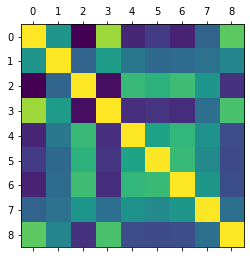

In [656]:
import matplotlib.pyplot as plt
plt.matshow(agg_merged_keywords_review_df.corr())
plt.show()